## A sample proof identifying Lemmas and generating by Derivatives


We illustrate some key features of proving by _learning_ with generative models based on Dependent Type Theory in the [ProvingGround](https://github.com/siddhartha-gadgil/ProvingGround) project. Some details of the project are available on its [website](http://siddhartha-gadgil.github.io/ProvingGround/).

We have a set $M$ with a binary operation $*$, and given elements $e_l$ and $e_m$. We also have terms correspoding to the assumptions

* $e_l * a = e_l$ for all $a\in M$ (left identity axiom),
* $a * e_r = e_r$ for all $a\in M$ (right identity axiom), 
* equality is symmetric and transitive.

From these, we conclude that basic algebraic result that $e_l = e_r$. Note that the proof in its fully expanded form is fairly long, involving the correct instantiations of each of the identity axioms, a use of symmetry of equality and a use of transitivity of equality. In particular it has very low weight in a direct generative model.

However, our system finds the proof quite readily (much less than a minute even running synchronously in the notebook), due to a few key principles.

* We use function application with _unification_, thus we can apply symmetry of equality directly to a term of type $a = b$ even though the type of symmetry is $\Pi_{x : M}\Pi_{y: M} x = y \to y= x$ as $x=a$ and $y=b$ are inferred.
* Most importantly, we learn that a lemma such as $e_l = e_l * e_r$, which is obtained by instantiation __and__ symmetry, is non-trivial (while only instantiation is not) based on a cost combining entropy of the initial distribution with the Kullback-Liebler divergence of _theorems_ (inhabited types) from _their proofs_.
* We also gain efficiency by using the _derivatives_ of the generative models to find consequences of lemmas.


We import the locally published  core of ProvingGround.

In [1]:
import $ivy.`io.github.siddhartha-gadgil::provingground-core-jvm:0.1.1-SNAPSHOT`

import $ivy.$                                                                   

We import the relevant packages, including the one with our example.

In [2]:
import provingground._ , interface._, HoTT._
import learning._
import library._, MonoidSimple._

import provingground._ , interface._, HoTT._

import learning._

import library._, MonoidSimple._

In [3]:
 repl.pprinter.bind(translation.FansiShow.fansiPrint)

To set up a _generator_. For simplicity in this demo, we are not generating $\lambda$'s and $\Pi$-types

In [4]:
val tg = TermGenParams(lmW=0, piW=0)

tg: TermGenParams = TermGenParams(
  0.1,
  0.1,
  0.1,
  0.0,
  0.0,
  0.05,
  0.05,
  0.05,
  0.0,
  0.0,
  0.0,
  0.0,
  0.3,
  0.7,
  0.5
)

We set up the initial state for learning.

In [5]:
val ts = TermState(dist1, dist1.map(_.typ))

ts: TermState = TermState(
  FiniteDistribution(
    Vector(
      Weighted(e_l, 0.047619047619047616),
      Weighted(e_r, 0.047619047619047616),
      Weighted(mul, 0.047619047619047616),
      Weighted(eqM, 0.047619047619047616),
      Weighted(axiom_{eqM(a)(a)}, 0.047619047619047616),
      Weighted(axiom_{(eqM(a)(b) \to eqM(b)(a))}, 0.047619047619047616),
      Weighted(axiom_{(eqM(a)(b) \to (eqM(b)(c) \to eqM(a)(c)))}, 0.047619047619047616),
      Weighted(axiom_{eqM(mul(e_l)(a))(a)}, 0.047619047619047616),
      Weighted(axiom_{eqM(mul(a)(e_r))(a)}, 0.047619047619047616),
      Weighted(eqM, 0.2857142857142857),
      Weighted(mul, 0.2857142857142857)
    )
  ),
  FiniteDistribution(
    Vector(
      Weighted(M, 0.047619047619047616),
      Weighted(M, 0.047619047619047616),
      Weighted((M → (M → M)), 0.047619047619047616),
      Weighted((M → (M → 𝒰 )), 0.047619047619047616),
      Weighted(∏(a : M){ eqM(a)(a) }, 0.047619047619047616),
      Weighted(∏(a : M){ ∏(b : M){ (eq

We use the _monix_ library for concurrency, though in this notebook we run code synchronously.

In [6]:
import monix.execution.Scheduler.Implicits.global 

import monix.execution.Scheduler.Implicits.global 

We synchronously evolve to the next state with our generative model.

In [7]:
val evT = tg.evolvedStateTask(ts, 0.0001)

evT: monix.eval.Task[EvolvedState] = Map(
  FlatMap(
    FlatMap(Async(<function2>, true, true, true), monix.eval.Task$$Lambda$2511/513186579@47287c59),
    provingground.learning.TermGenParams$$Lambda$2512/577936535@f08dfd8
  ),
  provingground.learning.TermGenParams$$Lambda$2513/2011333481@75d63383,
  0
)

In [8]:
val ev = evT.runSyncUnsafe() 

ev: EvolvedState = EvolvedState(
  TermState(
    FiniteDistribution(
      Vector(
        Weighted(e_l, 0.047619047619047616),
        Weighted(e_r, 0.047619047619047616),
        Weighted(mul, 0.047619047619047616),
        Weighted(eqM, 0.047619047619047616),
        Weighted(axiom_{eqM(a)(a)}, 0.047619047619047616),
        Weighted(axiom_{(eqM(a)(b) \to eqM(b)(a))}, 0.047619047619047616),
        Weighted(axiom_{(eqM(a)(b) \to (eqM(b)(c) \to eqM(a)(c)))}, 0.047619047619047616),
        Weighted(axiom_{eqM(mul(e_l)(a))(a)}, 0.047619047619047616),
        Weighted(axiom_{eqM(mul(a)(e_r))(a)}, 0.047619047619047616),
        Weighted(eqM, 0.2857142857142857),
        Weighted(mul, 0.2857142857142857)
      )
    ),
    FiniteDistribution(
      Vector(
        Weighted(M, 0.047619047619047616),
        Weighted(M, 0.047619047619047616),
        Weighted((M → (M → M)), 0.047619047619047616),
        Weighted((M → (M → 𝒰 )), 0.047619047619047616),
        Weighted(∏(a : M){ eqM(a)(a) }

### Identifying Lemmas

We identify lemmas as types that we know to be inhabited but are not inhabited by terms in the generating set. We have kept things simple, so there are fewer lemmas to start with. But the main step is _learning_ the weights of the lemmas.

The evolution of weights is generated as an _iterator_. As this is a structure that is generated just once, we store it as a _stream_, which is a lazy, infinite list.

In [9]:
import EntropyAtomWeight._ 
val its = evolvedLemmaIters(ev)

import EntropyAtomWeight._ 

its: Vector[(Typ[Term], Iterator[Double])] = Vector(
  (eqM(e_r)(e_r), <iterator>),
  (eqM(e_l)(e_l), <iterator>),
  (eqM(e_l)(mul(e_l)(e_r)), <iterator>),
  (eqM(e_l)(mul(e_l)(e_l)), <iterator>),
  (eqM(e_r)(mul(e_l)(e_r)), <iterator>),
  (eqM(e_r)(mul(e_r)(e_r)), <iterator>)
)

In [10]:
val streams = its.map{case (tp, it) => (tp, it.toStream)} 

streams: Vector[(Typ[Term], Stream[Double])] = Vector(
  (
    eqM(e_r)(e_r),
    Stream(
      0.002857590838241586,
      0.002870284580011658,
      0.0028830326027385837,
      0.0028958347689527876,
      0.0029086909332057907,
      0.002921600941988215,
      0.0029345646336491845,
      0.0029475818383171673,
      0.0029606523778223323,
      0.0029737760656204973,
      0.002986952706718721,
      0.003000182097602629,
      0.0030134640261655116,
      0.003026798271639304,
      0.003040184604527482,
      0.0030536227865399566,
      0.0030671125705300506,
      0.003080653700433604,
      0.00309424591121029,
      0.0031078889287872117,
      0.0031215824700048514,
      0.003135326242565432,
      0.0031491199449837654,
      0.0031629632665406593,
      0.003176855887238952,
      0.0031907974777622265,
      0.0032047876994362955,
      0.003218826204193503,
      0.003232912634539929,
      0.003247046623525527,
      0.003261227794717313,
      0.0032754557621756017

We see three snapshots of the evolution of weights, at times $0$, $1000$ and $10000$. We also plot the evolution below.

In [11]:
streams.map{case (tp, s) => (tp, s(0), s(1000), s(10000))}

res10: Vector[(Typ[Term], Double, Double, Double)] = Vector(
  (eqM(e_r)(e_r), 0.002857590838241586, 0.007232640857342379, 0.007232881599863632),
  (eqM(e_l)(e_l), 0.002857590838241586, 0.007232640857342379, 0.007232881599863632),
  (eqM(e_l)(mul(e_l)(e_r)), 2.1343143385081897E-4, 0.0022517955038286208, 0.002264523582244723),
  (eqM(e_l)(mul(e_l)(e_l)), 2.1343143385081897E-4, 0.0022517955038286208, 0.002264523582244723),
  (eqM(e_r)(mul(e_l)(e_r)), 2.1343143385081897E-4, 0.0022517955038286208, 0.002264523582244723),
  (eqM(e_r)(mul(e_r)(e_r)), 2.1343143385081897E-4, 0.0022517955038286208, 0.002264523582244723)
)

In [12]:
import $ivy.`org.plotly-scala::plotly-almond:0.5.2`

import plotly._
import plotly.element._
import plotly.layout._
import plotly.Almond._

import $ivy.$                                      


import plotly._

import plotly.element._

import plotly.layout._

import plotly.Almond._

In [13]:
val scatters = streams.map{case (typ, s) => Scatter((1 to 50).map(i => (i * 50)), (1 to 50).map(i => s(i * 50)), name=typ.toString )}
val tsdata = Seq(scatters: _*)

scatters: Vector[Scatter] = Vector(
  Scatter(
    Some(
      Doubles(
        Vector(
          50.0,
          100.0,
          150.0,
          200.0,
          250.0,
          300.0,
          350.0,
          400.0,
          450.0,
          500.0,
          550.0,
          600.0,
          650.0,
          700.0,
          750.0,
          800.0,
          850.0,
          900.0,
          950.0,
          1000.0,
          1050.0,
          1100.0,
          1150.0,
          1200.0,
          1250.0,
          1300.0,
          1350.0,
          1400.0,
          1450.0,
          1500.0,
          1550.0,
          1600.0,
          1650.0,
          1700.0,
          1750.0,
          1800.0,
          1850.0,
          1900.0,
          1950.0,
          2000.0,
          2050.0,
          2100.0,
          2150.0,
          2200.0,
...
tsdata: Seq[Scatter] = List(
  Scatter(
    Some(
      Doubles(
        Vector(
          50.0,
          100.0,
          150.0,
     

### Plot of the evolution

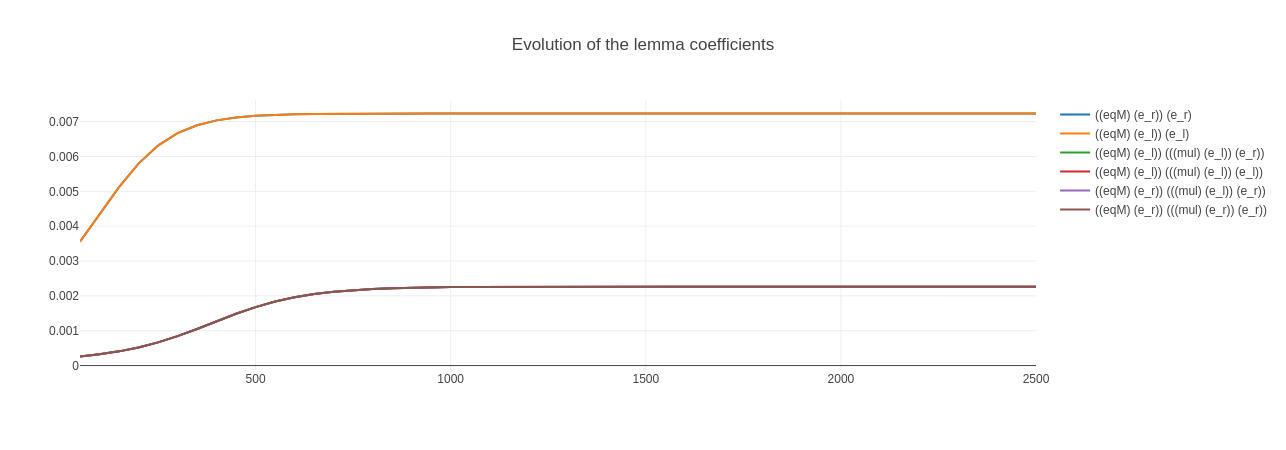

res13: String = "plot-1025472177"

In [14]:
tsdata.plot(title="Evolution of the lemma coefficients")

We pick the lemma that will give us the result. Note that there are four lemmas that have high weight after the evolution, two of which will work, so one could evolve along all of them (which we do in the interactive code).

In [15]:
val pf = "lemma" :: toTyp(streams(4)._1)
pf.typ

pf: U = lemma
res14_1: Typ[U] = eqM(e_r)(mul(e_l)(e_r))

### Using the lemma

For quick further exploration, we use the _derivatives_ of the recursive generating rules in the direction of the new lemma.

In [16]:
val tt = tg.nextTangStateTask(ev.result, TermState(FiniteDistribution.unif(pf), FiniteDistribution.empty), math.pow(10.0, -4)) 

tt: monix.eval.Task[TermState] = FlatMap(
  FlatMap(Async(<function2>, true, true, true), monix.eval.Task$$Lambda$2511/513186579@4bf5f76b),
  provingground.learning.TermGenParams$$Lambda$3206/1120831440@9e0753f
)

In [17]:
val tts = tt.runSyncUnsafe()

tts: TermState = TermState(
  FiniteDistribution(
    Vector(
      Weighted(
        (_ : eqM(mul(e_r)(e_l))($xuar)) ↦ axiom_{(eqM(a)(b) \to (eqM(b)(c) \to eqM(a)(c)))}(mul(e_r)(e_l))(e_r)(mul(e_l)(e_r))($xubb)(lemma),
        4.2905968897362E-4
      ),
      Weighted((_ : M) ↦ (@b : M) ↦ @b, 0.003605207867424719),
      Weighted((@a : M) ↦ (_ : M) ↦ @a, 0.002523645507197304),
      Weighted((@a : M) ↦ mul(@a), 0.01827497815647582),
      Weighted(
        axiom_{(eqM(a)(b) \to eqM(b)(a))}(e_r)(mul(e_l)(e_r))(axiom_{(eqM(a)(b) \to eqM(b)(a))}(mul(e_l)(e_r))(e_r)(axiom_{(eqM(a)(b) \to eqM(b)(a))}(e_r)(mul(e_l)(e_r))(lemma))),
        6.994803101713373E-4
      ),
      Weighted(
        (_ : eqM(mul(e_r)(e_l))($xvcr)) ↦ axiom_{(eqM(a)(b) \to (eqM(b)(c) \to eqM(a)(c)))}(mul(e_r)(e_l))(mul(e_l)(e_r))(e_r)($xvdp)(axiom_{(eqM(a)(b) \to eqM(b)(a))}(e_r)(mul(e_l)(e_r))(lemma)),
        7.88260512180325E-5
      ),
      Weighted(lemma, 0.6511923369378043),
      Weighted(
        axiom_{(eq

## The Proof

The next step indeed gives a proof of the desired result $e_l = e_r$. Note that this has a high weight of 1.2%

In [18]:
tts.terms.filter(_.typ == eqM(l)(r)) 

res17: FiniteDistribution[Term] = FiniteDistribution(
  Vector(
    Weighted(
      axiom_{(eqM(a)(b) \to eqM(b)(a))}(e_r)(e_l)(axiom_{(eqM(a)(b) \to (eqM(b)(c) \to eqM(a)(c)))}(e_r)(mul(e_l)(e_r))(e_l)(lemma)(axiom_{eqM(mul(a)(e_r))(a)}(e_l))),
      1.2963246194129427E-4
    )
  )
)